In [2]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
from matplotlib import pyplot as plt
# import tqdm
from tqdm import tqdm
import pdb
import random

In [3]:
np.random.seed(6312)
random.seed(7272)

# Part 1: Naive CNN
Last Spring, I took CS 189, where I build a CNN in a conventional way: Look at previous examples and blindly experiment off of them. I will start with that network, calculate the MEC, and make a better one.

Forgive me if some of the decisions here look silly, I did not know much about CNNs or deep learning back in the day.

In [4]:
from torchvision.transforms.autoaugment import F
### YOUR CODE HERE ###

def make_epoch_plot(epochs, train, valid, plt_type="Loss", problem_name="MLP on FashionMNIST"):
    plt.plot(epochs, train, label=f"Training {plt_type}")
    plt.plot(epochs, valid, label=f"Validation {plt_type}")
    plt.title(f'Training and Validation {plt_type} vs. Epochs for {problem_name}')
    plt.xlabel('Epoch Number')
    plt.ylabel(plt_type)
    plt.legend()
    plt.show()

In [5]:
# Creating the datasets, feel free to change this as long as you do the same to the test data.
# You can also modify this to split the data into training and validation.
# See https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

transform = torchvision.transforms.ToTensor()

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)
print(len(training_data))
validation_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

print(len(validation_data))
# If you make a train-test partition it is up to you.

Files already downloaded and verified
50000
Files already downloaded and verified
10000


In [6]:
print(training_data[1][0].shape)
print(len(training_data))

torch.Size([3, 32, 32])
50000


## The Original CNN

In [7]:
class MikeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 128, 3)
    self.conv2 = nn.Conv2d(128, 256, 3)
    self.dropout1 = nn.Dropout(0.4)
    self.conv3 = nn.Conv2d(256, 512, 3)
    self.dropout2 = nn.Dropout(0.4)
    self.conv4 = nn.Conv2d(512, 1024, 3)

    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(1024 * 3 * 3, 512)
    self.dropout3 = nn.Dropout(0.4)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2)
    # If the size is a square, you can specify with a single number
    x = F.relu(self.conv2(x))
    x = self.dropout1(x)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv4(x))
    x = self.dropout2(x)
    #x = F.relu(self.conv5(x))
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    #x = F.softmax(self.fc3(x), dim=1)
    x = self.fc3(x)
    return x

In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
criterion = torch.nn.CrossEntropyLoss()


def predict(model, dataloader, test=False):
  with torch.no_grad():
      losses = []
      model.eval() # Put model in eval mode
      num_correct = 0
      # i = 0
      # pred_vec = torch.zeros([len(dataloader.dataset), 1])
      pred_vec = []
      for x, y in dataloader:
          x, y = x.float().to(device), y.float().to(device)
          pred = model(x)
          pred_nums = torch.argmax(pred, dim=1)
          correct_in_batch = torch.sum(torch.round(pred_nums) == y).item()
          # if correct_in_batch < 5:
          #     #print(f"MAJOR ISSUE: correct_in_batch: {correct_in_batch}")
          #     print(f"pred: {pred}")
          #     print(f"pred_nums: {pred_nums}")
          #     print(f"correct_in_batch: {correct_in_batch};  len(x): {x.shape[0]}")
          #     print(f"y: {y}")
          #     print(f"Thing: {torch.round(pred_nums) == y}")
          num_correct += correct_in_batch
          loss = criterion(pred, y.long())
          losses.append(loss.item())
          if test:
            pred_vec += torch.flatten(pred_nums).tolist()
      acc = num_correct / len(dataloader.dataset)

      #print(f"Accuracy: {acc}; num_correct: {num_correct}; length: {len(dataloader.dataset)}")
      mean_loss = np.mean(losses)
      model.train() # Put model back in train mode
      return acc, mean_loss


Using device cuda


## Training the Original CNN

Using device cuda


  0%|          | 0/3334 [00:00<?, ?batch/s]/home/pingpong-michael/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 3334/3334 [00:23<00:00, 139.38batch/s]


Finished Epoch 1!
Predicting for training...
Training loss: 1.5926949024629506 ... Training accuracy: 0.40728
Predicting for validation...


  1%|          | 21/3334 [00:00<00:15, 207.07batch/s]

Validation loss: 1.596114438513051 ... Validation accuracy: 0.4094


100%|██████████| 3334/3334 [00:23<00:00, 143.84batch/s]


Finished Epoch 2!
Predicting for training...
Training loss: 1.2590364781266998 ... Training accuracy: 0.55004
Predicting for validation...


  1%|          | 19/3334 [00:00<00:17, 187.07batch/s]

Validation loss: 1.2929324309329042 ... Validation accuracy: 0.5377


100%|██████████| 3334/3334 [00:20<00:00, 163.26batch/s]


Finished Epoch 3!
Predicting for training...
Training loss: 1.0161486104640263 ... Training accuracy: 0.6448
Predicting for validation...


  1%|          | 24/3334 [00:00<00:13, 238.07batch/s]

Validation loss: 1.0914901516873619 ... Validation accuracy: 0.6157


100%|██████████| 3334/3334 [00:16<00:00, 199.67batch/s]


Finished Epoch 4!
Predicting for training...
Training loss: 0.82025352329123 ... Training accuracy: 0.71262
Predicting for validation...


  1%|          | 21/3334 [00:00<00:16, 199.74batch/s]

Validation loss: 0.9444111590978802 ... Validation accuracy: 0.671


100%|██████████| 3334/3334 [00:21<00:00, 158.73batch/s]


Finished Epoch 5!
Predicting for training...
Training loss: 0.649613116597997 ... Training accuracy: 0.77336
Predicting for validation...


  1%|          | 21/3334 [00:00<00:16, 199.30batch/s]

Validation loss: 0.8250397782007615 ... Validation accuracy: 0.715


100%|██████████| 3334/3334 [00:21<00:00, 152.07batch/s]


Finished Epoch 6!
Predicting for training...
Training loss: 0.5655677155504952 ... Training accuracy: 0.80892
Predicting for validation...


  1%|          | 22/3334 [00:00<00:15, 209.84batch/s]

Validation loss: 0.7835045152160897 ... Validation accuracy: 0.7276


100%|██████████| 3334/3334 [00:22<00:00, 151.36batch/s]


Finished Epoch 7!
Predicting for training...
Training loss: 0.4522990553578933 ... Training accuracy: 0.8544
Predicting for validation...


  1%|          | 21/3334 [00:00<00:16, 203.21batch/s]

Validation loss: 0.7419955672799557 ... Validation accuracy: 0.7547


100%|██████████| 3334/3334 [00:19<00:00, 170.89batch/s]


Finished Epoch 8!
Predicting for training...
Training loss: 0.38580609834459667 ... Training accuracy: 0.87102
Predicting for validation...


  1%|          | 21/3334 [00:00<00:16, 205.01batch/s]

Validation loss: 0.7320909926938689 ... Validation accuracy: 0.7546


100%|██████████| 3334/3334 [00:20<00:00, 161.85batch/s]


Finished Epoch 9!
Predicting for training...
Training loss: 0.28544270258087356 ... Training accuracy: 0.90686
Predicting for validation...


  1%|          | 20/3334 [00:00<00:16, 197.82batch/s]

Validation loss: 0.6915121328258801 ... Validation accuracy: 0.77


100%|██████████| 3334/3334 [00:19<00:00, 173.73batch/s]


Finished Epoch 10!
Predicting for training...
Training loss: 0.24363448596087378 ... Training accuracy: 0.92698
Predicting for validation...


  1%|          | 21/3334 [00:00<00:16, 202.07batch/s]

Validation loss: 0.6752655784385851 ... Validation accuracy: 0.7767


100%|██████████| 3334/3334 [00:19<00:00, 174.19batch/s]


Finished Epoch 11!
Predicting for training...
Training loss: 0.18431391254213794 ... Training accuracy: 0.94358
Predicting for validation...


  1%|          | 21/3334 [00:00<00:16, 203.17batch/s]

Validation loss: 0.6868436444310592 ... Validation accuracy: 0.784


100%|██████████| 3334/3334 [00:19<00:00, 168.03batch/s]


Finished Epoch 12!
Predicting for training...
Training loss: 0.15198863589430556 ... Training accuracy: 0.95472
Predicting for validation...


  1%|          | 25/3334 [00:00<00:13, 242.13batch/s]

Validation loss: 0.7215019204644025 ... Validation accuracy: 0.7771


100%|██████████| 3334/3334 [00:20<00:00, 164.81batch/s]


Finished Epoch 13!
Predicting for training...
Training loss: 0.12098954250825425 ... Training accuracy: 0.96614
Predicting for validation...


  1%|          | 20/3334 [00:00<00:16, 199.78batch/s]

Validation loss: 0.7111776653492915 ... Validation accuracy: 0.7836


100%|██████████| 3334/3334 [00:19<00:00, 168.74batch/s]


Finished Epoch 14!
Predicting for training...
Training loss: 0.12764672752906667 ... Training accuracy: 0.96356
Predicting for validation...


  1%|          | 21/3334 [00:00<00:16, 199.55batch/s]

Validation loss: 0.742181000027476 ... Validation accuracy: 0.7751


100%|██████████| 3334/3334 [00:22<00:00, 149.77batch/s]


Finished Epoch 15!
Predicting for training...
Training loss: 0.11277921747510675 ... Training accuracy: 0.9698
Predicting for validation...
Validation loss: 0.7613251199987696 ... Validation accuracy: 0.7695


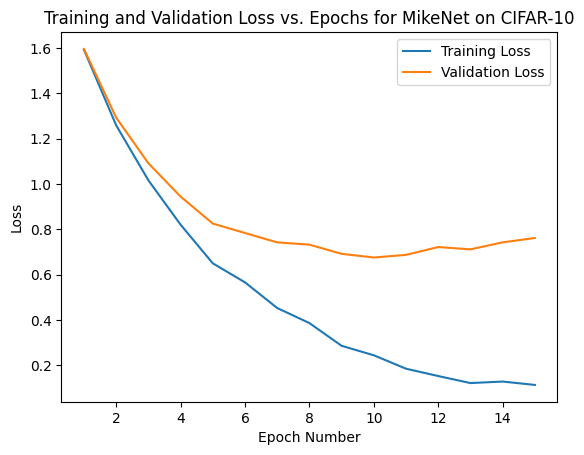

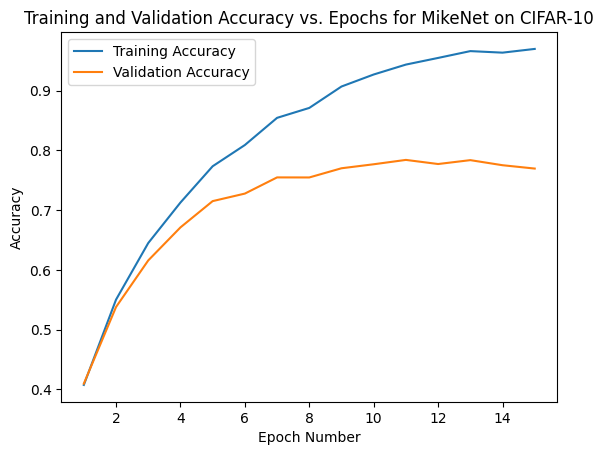

In [9]:
### YOUR CODE HERE ###
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 15
batch_size = 15
learning_rate = 0.005
#learning_rate = 0.01

num_features = np.prod(list(training_data[0][0].shape))
#print(f"Num features: {num_features}; Model params: {model.parameters()}")
model = MikeNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
train_accs = []
valid_accs = []
mean_train_losses = []
mean_valid_losses = []
epoch_list = []
for epoch in range(epochs):
    for x, y in tqdm(train_dataloader, unit="batch"):
        #x = torch.reshape(x, (x.shape[0], -1))
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y.long())
        loss.backward()
        optimizer.step()
        #train_losses.append(loss.item())

    print(f"Finished Epoch {epoch + 1}!")
    epoch_list.append(epoch + 1)
    print("Predicting for training...")
    train_acc, train_loss = predict(model, train_dataloader)
    print(f"Training loss: {train_loss} ... Training accuracy: {train_acc}")
    print("Predicting for validation...")
    valid_acc, valid_loss = predict(model, valid_dataloader)
    print(f"Validation loss: {valid_loss} ... Validation accuracy: {valid_acc}")

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    mean_train_losses.append(train_loss)
    mean_valid_losses.append(valid_loss)


    # print(f"Finished Epoch{epoch + 1}\nTraining loss: {np.mean(train_losses)}")

# We can run predictions on the data to determine the final accuracy.
make_epoch_plot(epoch_list, mean_train_losses, mean_valid_losses, plt_type="Loss", problem_name="MikeNet on CIFAR-10")
make_epoch_plot(epoch_list, train_accs, valid_accs, plt_type="Accuracy", problem_name="MikeNet on CIFAR-10")




## Original Model Analysis

### Performance: The model acheives 90% train accuracy and 75.6% validation accuracy

### Let's look at the architecture

```
self.conv1 = nn.Conv2d(3, 128, 3) 
self.conv2 = nn.Conv2d(128, 256, 3) # input: [b, 30, 30, 128]. output: [b, 28, 28, 256]
self.dropout1 = nn.Dropout(0.4)
self.conv3 = nn.Conv2d(256, 512, 3) # input: [b, 28, 28, 256]. output: [b, 26, 26, 512]
self.dropout2 = nn.Dropout(0.4)
self.conv4 = nn.Conv2d(512, 1024, 3) # input: [b, 26, 26, 512]. output: [b, 24, 24, 1024]

self.fc1 = nn.Linear(1024 * 3 * 3, 512)
self.dropout3 = nn.Dropout(0.4)
self.fc2 = nn.Linear(512, 128)
self.fc3 = nn.Linear(128, 10)


def forward(self, x):
    x = F.relu(self.conv1(x)) # input: [b, 32, 32, 3]. output: [b, 30, 30, 128]
    x = F.max_pool2d(x, 2) # input: [b, 32, 32, 3]. output: [b, 15, 15, 128]
    x = F.relu(self.conv2(x)) # input: [b, 15, 15, 128]. output: [b, 13, 13, 256]
    x = self.dropout1(x)
    x = F.relu(self.conv3(x)) # input: [b, 13, 13, 256]. output: [b, 11, 11, 512]
    x = F.max_pool2d(x, 2) # input: [b, 11, 11, 512]. output: [b, 5, 5, 512]
    x = F.relu(self.conv4(x)) # input: [b, 5, 5, 512]. output: [b, 3, 3, 512]
    x = self.dropout2(x)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    #x = F.softmax(self.fc3(x), dim=1)
    x = self.fc3(x)
    return x

```

### Compression
In terms of compression from the convolution, I have discovered something quite silly about this network... It seems this network didn't actually compress anything at all.
That is, the compression ratio is: b * 32 * 32 * 3 / (b * 3 * 3 * 1024) = 1/3
(Again, in my defense, I really did not know what I was doing, but at least these methods formalize that I did not know wtf I was doing.)
By the data impression inequality, this part of the model is too big jusy by the fact that I am trying to "create" information

### MEC: 

(1024 * 3 * 3 + 1) * 512 + 512 + 128 = 4719744 bits MEC 
Wow that's way too much!




In [7]:
def conv_output_dim(input_dim, pad, kernel, stride):
    return int((input_dim + 2 * pad - kernel) / stride + 1)

def pool_output_dim(input_dim, pad, kernel, stride):
    return int((input_dim + 2 * pad - (kernel - 1) - 1) / stride + 1)

In [8]:
print(conv_output_dim(14, 0, 3, 1))
print(pool_output_dim(12, 0, 2, 2))

12
6


In [20]:
def og_algo_8(X, y, num_classes=2):
    table = [(sum(X[i]), y[i]) for i in range(X.shape[0])]
    table = sorted(table, key=lambda x: x[0])
    thresholds = 0
    c = 0
    for i in range(len(table)):
        if not table[i][1] == c:
            c = table[i][1]
            thresholds += 1

    minthreshs = np.log(thresholds) / np.log(num_classes)
    # minthreshs = np.log2(thresholds)
    mec = minthreshs * (X.shape[1] + 1) + minthreshs + 1
    return thresholds, minthreshs, mec

X = [training_data[i][0] for i in range(len(training_data))]
X = np.array(X)
X = X.reshape(X.shape[0], -1)
y = [training_data[i][1] for i in range(len(training_data))]
y = np.array(y)
print(X.shape)
print(y.shape)

og_algo_8(X, y, num_classes=10)
# print(og_algo_8(training_data))

(50000, 3072)
(50000,)


(44304, 4.646442938401499, 14284.165592646208)

# Adjustments based off of MEC

### Calculating necessary MEC: 
There are 50000 data points and 10 classes. log_2(10) = 4; 4 * 50000 = 200000 bits of necessary MEC. 
Let's make the MLP of the following architecture:
(1024, 256)
(256, 64)
(64, 10)
This would have (1024 + 1) * 256 + 256 + 64 = 262720 bits of MEC. (Still 62720 over necessary).

Making the input to the MLP 1024 features would also make the compression ratio of all convolutional layers 32 * 32 * 3 / 1024 = 3


### New CNN

In [26]:
class MikeNetMEC(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 3) # 32 > 30
    self.conv2 = nn.Conv2d(64, 256, 3) # 30 > 28
    self.max1 = nn.MaxPool2d(2) # 28 > 14
    self.dropout1 = nn.Dropout(0.4)
    self.conv3 = nn.Conv2d(256, 512, 3) # 14 > 12
    self.max2 = nn.MaxPool2d(2) # 12 > 6
    self.dropout2 = nn.Dropout(0.4)
    
    self.conv4 = nn.Conv2d(512, 512, 4) # 6 > 3
    self.max3 = nn.MaxPool2d(2) # 3 > 1


    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(512, 10)
    self.dropout3 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(10, 10)
    self.fc3 = nn.Linear(10, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.max1(x)
    # x = self.dropout1(x)  

    x = F.relu(self.conv3(x))
    x = self.max2(x)
    # print(x.shape)

    x = F.relu(self.conv4(x))
    x = self.max3(x)
    # x = self.dropout2(x)

    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    # x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  0%|          | 15/3334 [00:00<00:22, 147.94batch/s]

Using device cuda


100%|██████████| 3334/3334 [00:20<00:00, 166.14batch/s]


Finished Epoch 1!
Training loss: 1.713013871744427 ... Training accuracy: 0.33524


  1%|          | 18/3334 [00:00<00:18, 178.16batch/s]

Validation loss: 1.7118743104019623 ... Validation accuracy: 0.3318


100%|██████████| 3334/3334 [00:22<00:00, 148.15batch/s]


Finished Epoch 2!
Training loss: 1.182292037512202 ... Training accuracy: 0.57892


  1%|          | 18/3334 [00:00<00:18, 174.90batch/s]

Validation loss: 1.226950609433776 ... Validation accuracy: 0.5622


100%|██████████| 3334/3334 [00:21<00:00, 155.85batch/s]


Finished Epoch 3!
Training loss: 0.937354852374471 ... Training accuracy: 0.66998


  1%|          | 18/3334 [00:00<00:18, 176.11batch/s]

Validation loss: 1.0611534198184778 ... Validation accuracy: 0.6252


100%|██████████| 3334/3334 [00:20<00:00, 158.95batch/s]


Finished Epoch 4!
Training loss: 0.7161969362764246 ... Training accuracy: 0.74556


  1%|          | 18/3334 [00:00<00:19, 173.14batch/s]

Validation loss: 0.9753051266141203 ... Validation accuracy: 0.6631


100%|██████████| 3334/3334 [00:21<00:00, 153.31batch/s]


Finished Epoch 5!
Training loss: 0.4463626861842668 ... Training accuracy: 0.84566


  1%|          | 18/3334 [00:00<00:18, 174.81batch/s]

Validation loss: 0.8639108732543785 ... Validation accuracy: 0.7174


100%|██████████| 3334/3334 [00:20<00:00, 163.12batch/s]


Finished Epoch 6!
Training loss: 0.2855917309021469 ... Training accuracy: 0.90954


  1%|          | 18/3334 [00:00<00:19, 172.98batch/s]

Validation loss: 0.8501825556047317 ... Validation accuracy: 0.7361


100%|██████████| 3334/3334 [00:20<00:00, 166.47batch/s]


Finished Epoch 7!
Training loss: 0.23441182274529773 ... Training accuracy: 0.92298


  1%|          | 18/3334 [00:00<00:19, 171.88batch/s]

Validation loss: 0.9950100913911923 ... Validation accuracy: 0.7264


100%|██████████| 3334/3334 [00:20<00:00, 163.82batch/s]


Finished Epoch 8!
Training loss: 0.13151012275567844 ... Training accuracy: 0.95836


  1%|          | 18/3334 [00:00<00:18, 179.31batch/s]

Validation loss: 0.983366910245331 ... Validation accuracy: 0.7447


100%|██████████| 3334/3334 [00:18<00:00, 175.67batch/s]


Finished Epoch 9!
Training loss: 0.19335494059258534 ... Training accuracy: 0.93556


  1%|          | 18/3334 [00:00<00:18, 179.97batch/s]

Validation loss: 1.22599275934341 ... Validation accuracy: 0.7058


100%|██████████| 3334/3334 [00:19<00:00, 175.20batch/s]


Finished Epoch 10!
Training loss: 0.13330978461091217 ... Training accuracy: 0.95638


  1%|          | 18/3334 [00:00<00:18, 179.86batch/s]

Validation loss: 1.2586138203469242 ... Validation accuracy: 0.7249


100%|██████████| 3334/3334 [00:20<00:00, 162.77batch/s]


Finished Epoch 11!
Training loss: 0.12789200397908815 ... Training accuracy: 0.95856


  1%|          | 18/3334 [00:00<00:18, 178.42batch/s]

Validation loss: 1.355973441667598 ... Validation accuracy: 0.7182


100%|██████████| 3334/3334 [00:21<00:00, 154.20batch/s]


Finished Epoch 12!
Training loss: 0.07394534049033956 ... Training accuracy: 0.9773


  1%|          | 18/3334 [00:00<00:18, 177.13batch/s]

Validation loss: 1.2048837538261241 ... Validation accuracy: 0.7417


100%|██████████| 3334/3334 [00:19<00:00, 174.65batch/s]


Finished Epoch 13!
Training loss: 0.06066856047646501 ... Training accuracy: 0.98072


  1%|          | 18/3334 [00:00<00:18, 176.66batch/s]

Validation loss: 1.3045140430107824 ... Validation accuracy: 0.7362


100%|██████████| 3334/3334 [00:20<00:00, 165.05batch/s]


Finished Epoch 14!
Training loss: 0.0550730169189157 ... Training accuracy: 0.983


  1%|          | 18/3334 [00:00<00:18, 176.62batch/s]

Validation loss: 1.4217555117360532 ... Validation accuracy: 0.738


100%|██████████| 3334/3334 [00:21<00:00, 155.90batch/s]


Finished Epoch 15!
Training loss: 0.07208590287813035 ... Training accuracy: 0.9802
Validation loss: 1.4092715434015155 ... Validation accuracy: 0.7394


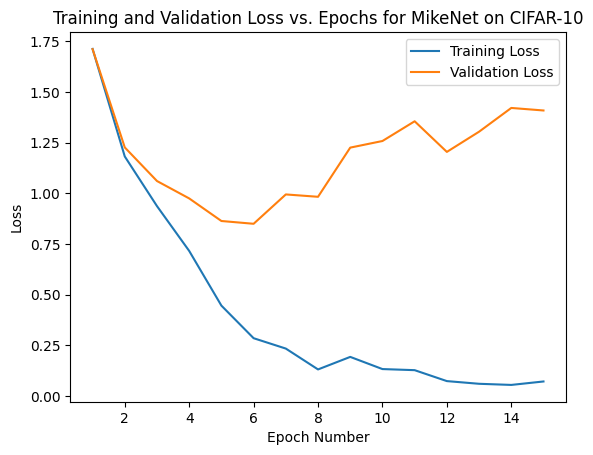

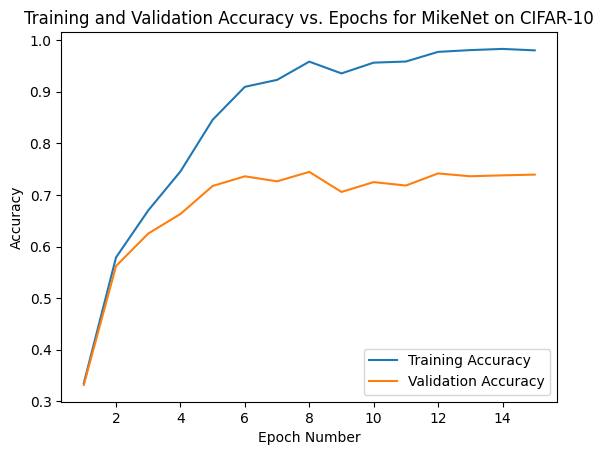

In [28]:
import torch.nn.functional as F

def train_model(model_instance):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device", device)

    epochs = 15
    batch_size = 15
    learning_rate = 0.005
    # learning_rate = 0.01

    num_features = np.prod(list(training_data[0][0].shape))
    #print(f"Num features: {num_features}; Model params: {model.parameters()}")
    model = model_instance.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = torch.nn.CrossEntropyLoss()
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

    model.train() # Put model in training mode
    train_accs = []
    valid_accs = []
    mean_train_losses = []
    mean_valid_losses = []
    epoch_list = []
    for epoch in range(epochs):
        for x, y in tqdm(train_dataloader, unit="batch"):
            #x = torch.reshape(x, (x.shape[0], -1))
            x, y = x.float().to(device), y.float().to(device)
            optimizer.zero_grad() # Remove the gradients from the previous step
            pred = model(x)
            loss = criterion(pred, y.long())
            loss.backward()
            optimizer.step()
            #train_losses.append(loss.item())

        print(f"Finished Epoch {epoch + 1}!")
        epoch_list.append(epoch + 1)
        # print("Predicting for training...")
        train_acc, train_loss = predict(model, train_dataloader)
        print(f"Training loss: {train_loss} ... Training accuracy: {train_acc}")
        # print("Predicting for validation...")
        valid_acc, valid_loss = predict(model, valid_dataloader)
        print(f"Validation loss: {valid_loss} ... Validation accuracy: {valid_acc}")

        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        mean_train_losses.append(train_loss)
        mean_valid_losses.append(valid_loss)


        # print(f"Finished Epoch{epoch + 1}\nTraining loss: {np.mean(train_losses)}")

    # We can run predictions on the data to determine the final accuracy.
    make_epoch_plot(epoch_list, mean_train_losses, mean_valid_losses, plt_type="Loss", problem_name="MikeNet on CIFAR-10")
    make_epoch_plot(epoch_list, train_accs, valid_accs, plt_type="Accuracy", problem_name="MikeNet on CIFAR-10")

train_model(MikeNetMEC())
